## Initialization before running this step

In [1]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import os
import pickle

from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from wordcloud import WordCloud
from scipy.stats import pointbiserialr

In [2]:
BASE_PATH = "LennarRemoteGitRepo/HousePricePrediction/"

In [5]:
train_df = pd.read_csv(f"../data/processed/train_cleaned_data.csv")
train_df.head()

,id,price,beds,baths,smoking_allowed,electric_vehicle_charge,lat,long,luxury_features,geo_cluster,...,type_condo,type_house,type_manufactured,region_cluster_2,state_ca,state_co,state_dc,state_hi,state_ks,state_ma
0,1.023725,2632,0.063173,0.864745,-1.669306,-0.112677,-0.613742,-1.541101,-0.336857,-0.694380,...,False,False,False,False,True,False,False,False,False,False
1,-0.556416,1160,0.063173,-0.839095,0.599051,-0.112677,-0.165086,-1.631841,-0.336857,-0.694380,...,False,False,False,False,True,False,False,False,False,False
2,-0.350927,1262,0.063173,-0.839095,-1.669306,-0.112677,1.498379,-1.822695,-0.336857,-0.694380,...,False,False,False,False,False,False,False,False,False,False
3,0.679433,1861,0.063173,0.864745,-1.669306,8.874963,0.497235,-0.764054,2.145337,2.255255,...,False,False,False,False,False,True,False,False,False,False
4,0.874458,626,-1.151463,-0.839095,-1.669306,-0.112677,1.136100,-0.259375,-0.336857,-0.325675,...,False,False,False,False,False,False,False,False,False,False


In [ ]:
test_df = pd.read_csv(f"../data/processed/test_cleaned_data.csv")
test_df.head()

In [ ]:
train_df_unscaled = pd.read_csv(f"../data/processed/train_cleaned_data_unscaled.csv")

In [ ]:
test_df_unscaled = pd.read_csv(f"../data/processed/test_cleaned_data_unscaled.csv")

## Building Models

In [6]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 332939 entries, 0 to 332938
Data columns (total 33 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   id                                  332939 non-null  float64
 1   price                               332939 non-null  int64  
 2   beds                                332939 non-null  float64
 3   baths                               332939 non-null  float64
 4   smoking_allowed                     332939 non-null  float64
 5   electric_vehicle_charge             332939 non-null  float64
 6   lat                                 332939 non-null  float64
 7   long                                332939 non-null  float64
 8   luxury_features                     332939 non-null  float64
 9   geo_cluster                         332939 non-null  float64
 10  region_freq                         332939 non-null  float64
 11  log_price                 

### 1. Linear Regression with Log Price

In [7]:
X_train = train_df.drop(columns=["log_price", "price"], axis=1)
y_train = train_df['log_price']

X_test = test_df.drop(columns=["log_price", "price"], axis=1)
y_test = test_df['log_price']

In [8]:
# Initialize and train the Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [9]:
# Make predictions
y_pred_log = model.predict(X_test)
y_pred_price = np.expm1(y_pred_log)

In [10]:
mae = mean_absolute_error(np.expm1(y_test), np.expm1(y_pred_log))  # Convert log_price back to price
mse = mean_squared_error(y_test, y_pred_log)
r2 = r2_score(y_test, y_pred_log)

print(f"Linear Regression Model Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Linear Regression Model Evaluation Metrics:
Mean Absolute Error (MAE): 276.5598
Mean Squared Error (MSE): 0.0936
R² Score: 0.4526


In [11]:
predictions_df = pd.DataFrame({"Actual Price": np.expm1(y_test), "Predicted Price": y_pred_price})
predictions_df.head(10)

,Actual Price,Predicted Price
0,1750.0,1632.246281
1,850.0,1266.461175
2,1500.0,1732.105960
3,899.0,867.576709
4,899.0,1164.940140
5,805.0,1044.535686
6,1300.0,1311.517860
7,735.0,456.272787
8,1070.0,986.581301
9,805.0,766.473508


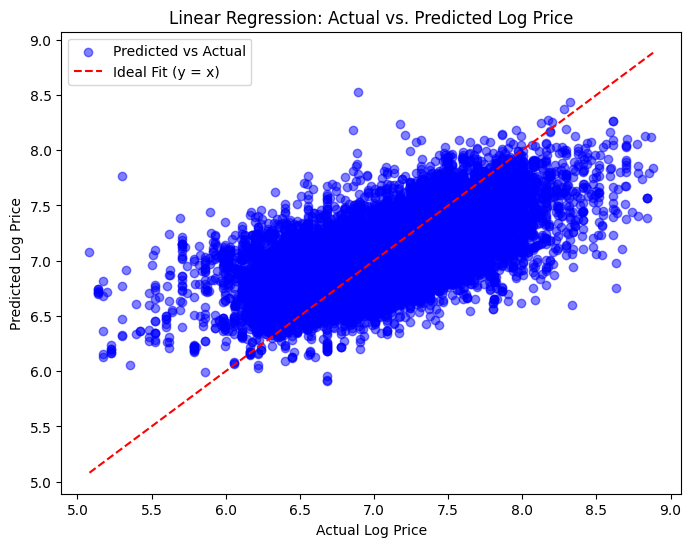

In [12]:
# Scatter plot of actual vs. predicted log_price values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_log, alpha=0.5, label="Predicted vs Actual", color="blue")

# Plot ideal prediction line (y = x) for reference
min_val = min(min(y_test), min(y_pred_log))
max_val = max(max(y_test), max(y_pred_log))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit (y = x)")

# Labels and title
plt.xlabel("Actual Log Price")
plt.ylabel("Predicted Log Price")
plt.title("Linear Regression: Actual vs. Predicted Log Price")
plt.legend()
plt.show()

### 2. RandomForest with Price

In [16]:
X_train = train_df_unscaled.drop(columns=["log_price", "price"], axis=1)
y_train = train_df_unscaled['price']

X_test = test_df_unscaled.drop(columns=["log_price", "price"], axis=1)
y_test = test_df_unscaled['price']

In [17]:
# Initialize and train the Random Forest Regressor model
randomforest_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
randomforest_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [18]:
# Make predictions on the test set
randomforest_y_pred = randomforest_model.predict(X_test)

In [19]:
# Calculate evaluation metrics
r2 = r2_score(y_test, randomforest_y_pred)
mae = mean_absolute_error(y_test, randomforest_y_pred)
mse = mean_squared_error(y_test, randomforest_y_pred)
rmse = np.sqrt(mse)

# Print results
print(f"Random Forest Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}  (Higher is better, max = 1)")
print(f"MAE: ${mae:.2f} (Lower is better, avg absolute error)")
print(f"MSE: {mse:.2f} (Lower is better, penalizes large errors)")
print(f"RMSE: ${rmse:.2f} (Lower is better, interpretable error in price units)")

Random Forest Model Evaluation Metrics:
R² Score: 0.8252  (Higher is better, max = 1)
MAE: $115.20 (Lower is better, avg absolute error)
MSE: 57591.04 (Lower is better, penalizes large errors)
RMSE: $239.98 (Lower is better, interpretable error in price units)


In [20]:
predictions_df = pd.DataFrame({"Actual Price": y_test, "Predicted Price": randomforest_y_pred})
predictions_df.head(10)

,Actual Price,Predicted Price
0,1750,1595.50
1,850,878.65
2,1500,1508.04
3,899,699.56
4,899,972.25
5,805,950.99
6,1300,1268.31
7,735,633.95
8,1070,1072.17
9,805,796.78


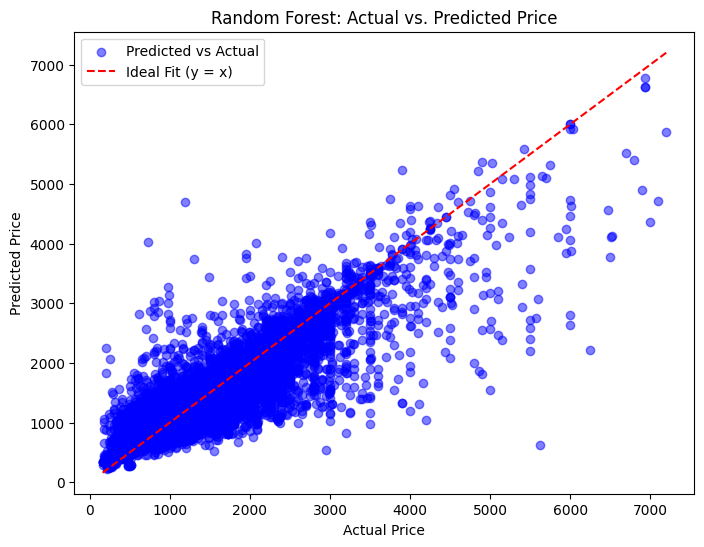

In [21]:
# Scatter plot of actual vs. predicted price values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, randomforest_y_pred, alpha=0.5, label="Predicted vs Actual", color="blue")

# Plot ideal prediction line (y = x) for reference
min_val = min(min(y_test), min(randomforest_y_pred))
max_val = max(max(y_test), max(randomforest_y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit (y = x)")

# Labels and title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs. Predicted Price")
plt.legend()
plt.show()

### 3. XGBoost

In [22]:
X_train = train_df_unscaled.drop(columns=["log_price", "price"], axis=1)
y_train = train_df_unscaled['price']

X_test = test_df_unscaled.drop(columns=["log_price", "price"], axis=1)
y_test = test_df_unscaled['price']

In [23]:
xgb_model = XGBRegressor(n_estimators=360, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=360, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [24]:
# Make predictions on the test set
xgb_preds = xgb_model.predict(X_test)

In [25]:
# Calculate evaluation metrics
r2 = r2_score(y_test, xgb_preds)
mae = mean_absolute_error(y_test, xgb_preds)
mse = mean_squared_error(y_test, xgb_preds)
rmse = np.sqrt(mse)

# Print results
print(f"XGBoost Model Evaluation Metrics for Price Prediction:")
print(f"R² Score: {r2:.4f}  (Higher is better, max = 1)")
print(f"MAE: ${mae:.2f} (Lower is better, avg absolute error)")
print(f"MSE: {mse:.2f} (Lower is better, penalizes large errors)")
print(f"RMSE: ${rmse:.2f} (Lower is better, interpretable error in price units)")

XGBoost Model Evaluation Metrics for Price Prediction:
R² Score: 0.7689  (Higher is better, max = 1)
MAE: $169.61 (Lower is better, avg absolute error)
MSE: 76130.66 (Lower is better, penalizes large errors)
RMSE: $275.92 (Lower is better, interpretable error in price units)


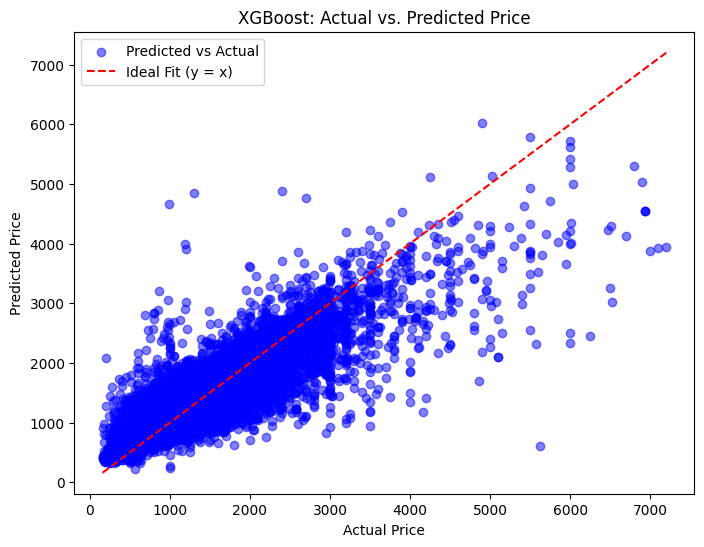

In [26]:
# Scatter plot of actual vs. predicted price values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, xgb_preds, alpha=0.5, label="Predicted vs Actual", color="blue")

# Plot ideal prediction line (y = x) for reference
min_val = min(min(y_test), min(xgb_preds))
max_val = max(max(y_test), max(xgb_preds))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit (y = x)")

# Labels and title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("XGBoost: Actual vs. Predicted Price")
plt.legend()
plt.show()

## HyperParameter Tuning

Tuning Random Forest hyperparameters

In [ ]:
X_train = train_df_unscaled.drop(columns=["log_price", "price"], axis=1)
y_train = train_df_unscaled['price']

X_test = test_df_unscaled.drop(columns=["log_price", "price"], axis=1)
y_test = test_df_unscaled['price']

In [ ]:
param_grid = {
    "n_estimators": [100, 200, 300],  # Number of trees
    "max_features" : [2, 4, 6, 8]
    # "max_depth": [None, 10, 20],  # Depth of trees
    # "min_samples_split": [2, 5, 10],  # Minimum samples per split
    # "min_samples_leaf": [1, 2, 4],  # Minimum samples per leaf
}

randomforest_model = RandomForestRegressor(random_state=42, n_jobs=2)

In [ ]:
grid_search = GridSearchCV(randomforest_model, param_grid, cv=5, scoring="neg_mean_squared_error", verbose=2)
grid_search.fit(X_train, y_train)

In [ ]:
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

In [ ]:
best_model = RandomForestRegressor(**best_params, random_state=42, n_jobs=-1)
best_model.fit(X_train, y_train)

In [ ]:
y_pred = best_model.predict(X_test)

In [ ]:
# Calculate evaluation metrics
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

# Print results
print(f"Random Forest Model Evaluation Metrics:")
print(f"R² Score: {r2:.4f}  (Higher is better, max = 1)")
print(f"MAE: ${mae:.2f} (Lower is better, avg absolute error)")
print(f"MSE: {mse:.2f} (Lower is better, penalizes large errors)")
print(f"RMSE: ${rmse:.2f} (Lower is better, interpretable error in price units)")

In [ ]:
# Scatter plot of actual vs. predicted price values
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5, label="Predicted vs Actual", color="blue")

# Plot ideal prediction line (y = x) for reference
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], linestyle="--", color="red", label="Ideal Fit (y = x)")

# Labels and title
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Random Forest: Actual vs. Predicted Price")
plt.legend()
plt.show()

## Saving Best Model

In [ ]:
# Save the trained model to disk in 'models' folder
os.makedirs("models", exist_ok=True)
model_path = f"../models/random_forest_price_model.pkl"
with open(model_path, "wb") as f:
    pickle.dump(randomforest_model, f)

print(f"Model saved successfully at: {model_path}")